### USX Anomaly Detection using DL

In [2]:
%load_ext watermark

In [3]:
%watermark -a 'Durga' -v -d -p numpy,pandas,matplotlib,sklearn,keras,seaborn

Using Theano backend.


Durga 2017-01-03 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
sklearn 0.18.1
keras 1.2.0
seaborn 0.7.1


In [46]:
%matplotlib inline

# general libs
import sys
import numpy as np
import pandas as pd
import sklearn

#plotting libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# date time libs
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm 

# ml libs
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# CSS Fileb
from IPython.core.display import HTML
from IPython.display import Image

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

In [25]:
# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Overview

Say you are an admin with N volumes. You use thresholds to detect anomalies and get alerts via SNMP/Email/Slack etc. While threshold based approaches are quite common, a big challenge is they expect the admin to know the workload & resources behavior on each and every one of their volumes. You set the thresholds too tight, you get too many alerts and gets ignored. You set them too loose and you don't catch them.

Anomaly detection is a vast field. This notebook utilizes LSTM RNN Deep Learning model to learn from data and detect anomalies.


### APIs...

In [5]:
##### DATA API ###########

def read_metric_data(csv_name):
    '''
        Read data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
    print("{0} --- #(rows:columns): {1}".format(csv_name, df.shape))
    return df

def rename_series(series, prefix='v'):
    s = series.unique()
    newS = pd.Series(np.arange(len(s), dtype=np.int))
    newS = newS.apply(lambda x:  prefix + str(x))
    d = dict(zip(s, newS))
    newSeries =series.map(d)
    return newSeries

def expand_df(df, ef=2, freq='D'):
    d = df.copy()
    d1 = pd.concat([df]*ef, ignore_index=True)
    d1.index = pd.date_range(df.index[0], periods=len(d1), freq=freq)
    return d1

In [12]:
##### Anomaly API ###########




def create_anomaly_plot(dataset, results, title='Title'):
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    ax[0].plot(dataset['timestamp'], dataset['value'], 'b')
    ax[0].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
    ax[0].set_title(title + ": " + 'Detected Anomalies')
    ax[1].set_xlabel('Time Stamp')
    ax[0].set_ylabel('Capacity (GB)')
    ax[1].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
    ax[1].set_ylabel('Anomaly Magnitude (GB)')
    plt.legend(loc='best')
    plt.show()


### Data Load & Data Preprocessing

In [7]:
# Read capacity used metric
df_used1 = read_metric_data("data/capacity/kelsey-capused-d.txt")
df_used2 = read_metric_data("data\capacity\dogfood-v1-capused-d.txt")
df_total = read_metric_data("data\capacity\dogfood-v1-captotal-d.txt")

# revise server values
df_used1.server = rename_series(df_used1.server, prefix="v")
df_used2.server = rename_series(df_used2.server, prefix="v")
df_total.server = rename_series(df_total.server, prefix="v")

# Preprocess Data
df_used1.loc[:,('value')] = (df_used1.value/(1024*1024*1024)).round(2)
df_used2.loc[:,('value')] = (df_used2.value/(1024*1024*1024)).round(2)
df_total.loc[:,('value')] = (df_total.value/(1024*1024*1024)).round(2)

# group data by server
g1 = df_used1.groupby('server')
g2 = df_used2.groupby('server')

#df.loc[:,'diff'] = df.value.diff()

data/capacity/kelsey-capused-d.txt --- #(rows:columns): (4156, 2)
data\capacity\dogfood-v1-capused-d.txt --- #(rows:columns): (92, 2)
data\capacity\dogfood-v1-captotal-d.txt --- #(rows:columns): (92, 2)


#### Summary stats...

In [9]:
# expand data
vdf0 = expand_df(g1.get_group("v0"), ef=10, freq='D')
vdf2 = expand_df(g2.get_group("v0"), ef=10, freq='D')
vdf40 = expand_df(g1.get_group("v40"), ef=10, freq='D')

summary = pd.DataFrame()
summary['v0'] = vdf0.describe().value
summary['v2'] = vdf2.describe().value
summary['v40'] = vdf40.describe().value
summary = summary.drop("count", axis=0)
summary = summary.round(2)

note: Also look for dark colors in each colums


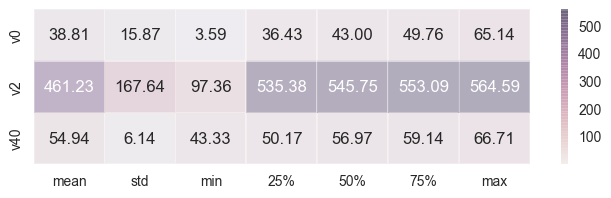

In [10]:
f, ax = plt.subplots(figsize=(8, 2))
sns.heatmap(summary.T, linewidths=.5, alpha=0.3, annot=True, fmt=".2f")
print("note: Also look for dark colors in each colums")

### Anomaly Detection

Below are 3 types of volume behaviors and automated anomaly detection. Notice how the detector handled the seasonal and trend characteristics. Currently the detector is configured for 95% confidence interval. 

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def transform_data(data):
    dataset = data.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return dataset, scaler

def inverse_transform_data(data, scaler):
    dataset = data.astype('float32')
    dataset = scaler.inverse_transform(data)
    return dataset
    
def model_rnn_lstm(dataset, seed=9, title='title'):
    # fix random seed for reproducibility
    np.random.seed(seed)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    look_back = 2
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
 
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_dim=look_back))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, nb_epoch=100, batch_size=2, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('%s:, Train_Score: %.2f RMSE, Test_Score: %.2f RMSE' % (title, trainScore, testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # Plot base lines & predictions
    fig = plt.figure(figsize=(12, 3))
    ax = plt.gca()
    plt.plot(scaler.inverse_transform(dataset), color='steelblue', linewidth=3, label='Original', alpha=0.7)
    plt.plot(trainPredictPlot, color='sage', label='TrainPredict')
    plt.plot(testPredictPlot, color='indianred', label='TestPredict')
    plt.xlabel("x", fontweight='bold')
    plt.ylabel("GB", fontweight='bold')
    plt.title(title + ": " + "Baseline & Predictions")
    plt.legend(loc='best')


In [48]:
# expand data
print("Type1: Cyclical Behavior")
vdf0 = expand_df(g1.get_group("v0"), ef=5, freq='D')

# normalize the dataset
dataset = vdf0[['value']].values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)    

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Building Model....')

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(12, input_dim=look_back,  return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4),  return_sequences=False)
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=2, verbose=0)

print('Making predictions....')

# make predictions
trainPredict = model.predict(trainX)
%time testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('%s:, Train_Score: %.2f RMSE, Test_Score: %.2f RMSE' % ('Title', trainScore, testScore))

Type1: Cyclical Behavior
Building Model....
Making predictions....
Wall time: 1e+03 µs
Title:, Train_Score: 7.73 RMSE, Test_Score: 6.96 RMSE


In [26]:
tPredict = model.predict(testX)
math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

1926.665230697208

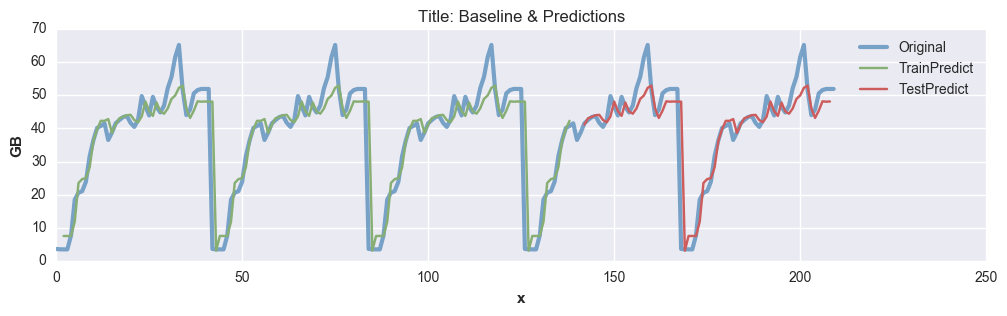

In [50]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot base lines & predictions
fig = plt.figure(figsize=(12, 3))
ax = plt.gca()
plt.plot(scaler.inverse_transform(dataset), color='steelblue', linewidth=3, label='Original', alpha=0.7)
plt.plot(trainPredictPlot, color='sage', label='TrainPredict')
plt.plot(testPredictPlot, color='indianred', label='TestPredict')
plt.xlabel("x", fontweight='bold')
plt.ylabel("GB", fontweight='bold')
plt.title('Title' + ": " + "Baseline & Predictions")
plt.legend(loc='best')

In [57]:
print(history.history.keys())


NameError: name 'history' is not defined